# WeRateDogs Data Wrangling Project

## Table of Contents
<ul>
<li><a href="#intro">Introduction</a></li>
<li><a href="#gather">Data Wrangling - Gather</a></li>
<li><a href="#assess">Data Wrangling - Assess</a></li>    
<li><a href="#clean">Data Wrangling - Clean</a></li>
<li><a href="#analyze">Analyze & Visualize</a></li>       
</ul>

<a id='intro'></a>
## Introduction

The purpose of this project is practising data wrangling techniques on three separate files.<br>
All wrangled files are related to the **twitter account @dog_rates (WeRateDogs)**.<br>
The project follows the wrangling workflow of **gather, assess, clean**.

<a id='gather'></a>
## Data Wrangling - Gather

There are three sources of data to gather:
1. **twitter enhanced archive file** - csv downloaded from udacity course site
2. **tweet image predictions file** - tsv requested from udacity site
3. **tweet details file** - json file downloaded from twitter using API

In [1160]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import requests
import tweepy
from tweepy import OAuthHandler
import json
from timeit import default_timer as timer
pd.set_option('display.max_colwidth', None) # to display the whole strings and not collapse them
pd.set_option('display.max_columns', None) # to not collapse columns when viewing data
pd.set_option('display.max_rows', None) # to display all rows in the output

### 1. **twitter enhanced archive file** (local file)

In [1161]:
# load csv file
df_archive = pd.read_csv('twitter-archive-enhanced.csv')
df_archive.head(2)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Phineas. He's a mystical boy. Only ever appears in the hole of a donut. 13/10 https://t.co/MgUWQ76dJU,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643555336193/photo/1,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","This is Tilly. She's just checking pup on you. Hopes you're doing ok. If not, she's available for pats, snugs, boops, the whole bit. 13/10 https://t.co/0Xxu71qeIV",NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421306343426/photo/1,13,10,Tilly,None,None,None,None


### 2. **tweet image predictions file** (url)

In [1162]:
# request tsv file
url = 'https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv'
response = requests.get(url)

# save the file
with open('image_predictions.tsv', mode = 'wb') as file:
    file.write(response.content)

# load the tab separated file
df_preds = pd.read_csv('image_predictions.tsv', sep='\t')
df_preds.head(2)

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True


### 3. **tweet details file** (API)

In [ ]:
# Query Twitter API for each tweet in the Twitter archive and save JSON in a text file

# These are hidden to comply with Twitter's API terms and conditions
consumer_key = 'HIDDEN'
consumer_secret = 'HIDDEN'
access_token = 'HIDDEN'
access_secret = 'HIDDEN'

auth = OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_secret)

api = tweepy.API(auth, wait_on_rate_limit=True, wait_on_rate_limit_notify=True)

# Tweet IDs for which to gather additional data via Twitter's API
tweet_ids = df_archive.tweet_id.values
print('Tweets to search for:', len(tweet_ids))

# Query Twitter's API for JSON data for each tweet ID in the Twitter archive
count = 0
success = 0
fails_dict = {}
start = timer()
# Save each tweet's returned JSON as a new line in a .txt file
with open('tweet_json.txt', 'w') as outfile:
    # This loop takes 20-30 minutes to run because of Twitter's rate limit
    for tweet_id in tweet_ids:
        count += 1
        if count % 100 == 0:
            print('#',count, 'processed tweet IDs')
        try:
            tweet = api.get_status(tweet_id, tweet_mode='extended')
            success += 1
            json.dump(tweet._json, outfile)
            outfile.write('\n')
        except tweepy.TweepError as e:
            print("Fail")
            fails_dict[tweet_id] = e
            pass
end = timer()

In [ ]:
print('Time to compose the file:', end - start)
print('Tweets found:', success)
print('Tweet IDs not found:', fails_dict)

In [1163]:
# read the just created tweet_json.txt file line by line to create a pandas DataFrame
# get tweet ID, retweet count, and like count

# a list to be converted to pd df
json_list = []

with open('tweet_json.txt', 'r') as json_file:
    json_row = json_file.readline()
    while json_row:
        json_dict = json.loads(json_row)    
        # each tweet is written in its own dictionary because that's how the file was created
        # we know the column names from visual inspection of the txt file or by reading 
        # https://developer.twitter.com/en/docs/tweets/data-dictionary/overview/tweet-object
        tweet_id = json_dict['id']
        retweet_count = json_dict['retweet_count']
        like_count = json_dict['favorite_count']
        # let's also get info about retweets to compare it with df_archive 
        # retweeted_status is only included when the tweet is a retweet:
        retweeted = json_dict.get('retweeted_status', 0)
        if retweeted != 0:
            retweeted = 1
         
        json_list.append({'tweet_id': tweet_id, 'retweets': retweet_count, 'likes': like_count, 'retweeted': retweeted})
        # new json row, i.e. next tweet
        json_row = json_file.readline()
        
# convert a list of dictionaries to df        
df_likes = pd.DataFrame(json_list, columns = ['tweet_id', 'retweets', 'likes', 'retweeted'])
df_likes.head(2)

,tweet_id,retweets,likes,retweeted
0,892420643555336193,8853,39467,0
1,892177421306343426,6514,33819,0


<a id='assess'></a>
## Data Wrangling - Assess

We only want to work with:<br>

1) original tweets

2) tweets with an image of a dog

The end results after assessing and cleaning should be one master file (if that will make sense based on tidiness rules), which includes only the relevant tweets (based on the above definition) and has all the required columns with corrected data in it.

Let's visually and programatically analyze all three data frames separately:

### 1. **twitter enhanced archive (df_archive)**

In [1164]:
df_archive.sample(10)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
468,817056546584727552,NaN,NaN,2017-01-05 17:13:55 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Chloe. She fell asleep at the wheel. Absolute menace on the roadways. Sneaky tongue slip tho. 11/10 https://t.co/r6SLVN2VUH,NaN,NaN,NaN,https://twitter.com/dog_rates/status/817056546584727552/photo/1,11,10,Chloe,None,None,None,None
1978,672984142909456390,NaN,NaN,2015-12-05 03:41:37 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Very happy pup here. Always smiling. Loves his little leaf. Carries it everywhere with him. 9/10 https://t.co/81BCQAyvcs,NaN,NaN,NaN,https://twitter.com/dog_rates/status/672984142909456390/photo/1,9,10,None,None,None,None,None
415,822647212903690241,NaN,NaN,2017-01-21 03:29:14 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",RT @dog_rates: This is Paisley. She really wanted to be president this time. Dreams officially crushed. 13/10 https://t.co/liJGwMp17E,8.224891e+17,4.196984e+09,2017-01-20 17:00:46 +0000,"https://twitter.com/dog_rates/status/822489057087389700/photo/1,https://twitter.com/dog_rates/status/822489057087389700/photo/1,https://twitter.com/dog_rates/status/822489057087389700/photo/1,https://twitter.com/dog_rates/status/822489057087389700/photo/1,https://twitter.com/dog_rates/status/822489057087389700/photo/1,https://twitter.com/dog_rates/status/822489057087389700/photo/1",13,10,Paisley,None,None,None,None
2319,666447344410484738,NaN,NaN,2015-11-17 02:46:43 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Scout. She is a black Downton Abbey. Isn't afraid to get dirty. 9/10 nothing bad to say https://t.co/kH60oka1HW,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666447344410484738/photo/1,9,10,Scout,None,None,None,None
268,841439858740625411,NaN,NaN,2017-03-14 00:04:30 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Here we have some incredible doggos for #K9VeteransDay. All brave as h*ck. Salute your dog in solidarity. 14/10 for all https://t.co/SVNMdFqKDL,NaN,NaN,NaN,"https://twitter.com/dog_rates/status/841439858740625411/photo/1,https://twitter.com/dog_rates/status/841439858740625411/photo/1,https://twitter.com/dog_rates/status/841439858740625411/photo/1,https://twitter.com/dog_rates/status/841439858740625411/photo/1",14,10,None,None,None,None,None
1470,694001791655137281,NaN,NaN,2016-02-01 03:38:15 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Chester. He's a Benefloof Cumberbark. Fabulous ears. Nifty shirt. Was probably on sale. Nice hardwood. 11/10 https://t.co/YoII7tWXMT,NaN,NaN,NaN,"https://twitter.com/dog_rates/status/694001791655137281/photo/1,https://twitter.com/dog_rates/status/694001791655137281/photo/1",11,10,Chester,None,None,None,None
1827,676430933382295552,NaN,NaN,2015-12-14 15:57:56 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","Meet Duke. He's an Urban Parmesan. They know he's scared of the green rubber dog. ""Why u do dis?"" thinks Duke. 10/10 https://t.co/3bim9U5Idr",NaN,NaN,NaN,https://twitter.com/dog_rates/status/676430933382295552/photo/1,10,10,Duke,None,None,None,None
304,836380477523124226,NaN,NaN,2017-02-28 01:00:19 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","This is Ava. She just blasted off. Streamline af. Aerodynamic as h*ck. One small step for pupper, one giant leap for pupkind. 12/10 https://t.co/W4KffrdX3Q",NaN,NaN,NaN,https://twitter.com/dog_rates/status/836380477523124226/photo/1,12,10,Ava,None,None,pupper,None
1731,679844490799091

In [1165]:
df_archive.info()
# in_reply and retweeted columns have nulls for all tweets that were not a reply or a retweet

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   tweet_id                    2356 non-null   int64  
 1   in_reply_to_status_id       78 non-null     float64
 2   in_reply_to_user_id         78 non-null     float64
 3   timestamp                   2356 non-null   object 
 4   source                      2356 non-null   object 
 5   text                        2356 non-null   object 
 6   retweeted_status_id         181 non-null    float64
 7   retweeted_status_user_id    181 non-null    float64
 8   retweeted_status_timestamp  181 non-null    object 
 9   expanded_urls               2297 non-null   object 
 10  rating_numerator            2356 non-null   int64  
 11  rating_denominator          2356 non-null   int64  
 12  name                        2356 non-null   object 
 13  doggo                       2356 

In [1166]:
df_archive.describe()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,retweeted_status_id,retweeted_status_user_id,rating_numerator,rating_denominator
count,2.356000e+03,7.800000e+01,7.800000e+01,1.810000e+02,1.810000e+02,2356.000000,2356.000000
mean,7.427716e+17,7.455079e+17,2.014171e+16,7.720400e+17,1.241698e+16,13.126486,10.455433
std,6.856705e+16,7.582492e+16,1.252797e+17,6.236928e+16,9.599254e+16,45.876648,6.745237
min,6.660209e+17,6.658147e+17,1.185634e+07,6.661041e+17,7.832140e+05,0.000000,0.000000
25%,6.783989e+17,6.757419e+17,3.086374e+08,7.186315e+17,4.196984e+09,10.000000,10.000000
50%,7.196279e+17,7.038708e+17,4.196984e+09,7.804657e+17,4.196984e+09,11.000000,10.000000
75%,7.993373e+17,8.257804e+17,4.196984e+09,8.203146e+17,4.196984e+09,12.000000,10.000000
max,8.924206e+17,8.862664e+17,8.405479e+17,8.874740e+17,7.874618e+17,1776.000000,170.000000


In [1167]:
# there are some extreme values, some of which are wrong based on the text
df_archive.rating_denominator.value_counts()

10     2333
11        3
50        3
80        2
20        2
2         1
16        1
40        1
70        1
15        1
90        1
110       1
120       1
130       1
150       1
170       1
7         1
0         1
Name: rating_denominator, dtype: int64

In [1168]:
df_archive.query('rating_denominator == 2').text

2335    This is an Albanian 3 1/2 legged  Episcopalian. Loves well-polished hardwood flooring. Penis on the collar. 9/10 https://t.co/d9NcXFKwLv
Name: text, dtype: object

In [1169]:
# there are some extreme values, some of which are wrong based on the text
df_archive.rating_numerator.value_counts()

12      558
11      464
10      461
13      351
9       158
8       102
7        55
14       54
5        37
6        32
3        19
4        17
1         9
2         9
420       2
0         2
15        2
75        2
80        1
20        1
24        1
26        1
44        1
50        1
60        1
165       1
84        1
88        1
144       1
182       1
143       1
666       1
960       1
1776      1
17        1
27        1
45        1
99        1
121       1
204       1
Name: rating_numerator, dtype: int64

In [1170]:
df_archive.query('rating_numerator == 960').text

313    @jonnysun @Lin_Manuel ok jomny I know you're excited but 960/00 isn't a valid rating, 13/10 is tho
Name: text, dtype: object

In [1171]:
# decimal rating numerator: the actual rating is 13.5/10, but 5/10 is extracted
# df_archive.iloc[45] ... the below code has a more leggible output
df_archive[df_archive.index==45]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
45,883482846933004288,NaN,NaN,2017-07-08 00:28:19 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","This is Bella. She hopes her smile made you smile. If not, she is also offering you her favorite monkey. 13.5/10 https://t.co/qjrljjt948",NaN,NaN,NaN,"https://twitter.com/dog_rates/status/883482846933004288/photo/1,https://twitter.com/dog_rates/status/883482846933004288/photo/1",5,10,Bella,None,None,None,None


In [1172]:
# some names are clearly not correctly extracted
df_archive.name.value_counts().nlargest(20)

None       745
a           55
Charlie     12
Cooper      11
Oliver      11
Lucy        11
Lola        10
Penny       10
Tucker      10
Winston      9
Bo           9
Sadie        8
the          8
Bailey       7
Toby         7
an           7
Daisy        7
Buddy        7
Koda         6
Bella        6
Name: name, dtype: int64

In [1173]:
# stages check
df_archive.query('doggo == "doggo"').sample(5)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
426,821407182352777218,NaN,NaN,2017-01-17 17:21:47 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Sundance. He's a doggo drummer. Even sings a bit on the side. 14/10 entertained af (vid by @sweetsundance) https://t.co/Xn5AQtiqzG,NaN,NaN,NaN,https://twitter.com/dog_rates/status/821407182352777218/video/1,14,10,Sundance,doggo,None,None,None
989,748932637671223296,NaN,NaN,2016-07-01 17:33:49 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Say hello to Divine Doggo. Must be magical af. 13/10 would be an honor to pet https://t.co/BbcABzohKb,NaN,NaN,NaN,https://twitter.com/dog_rates/status/748932637671223296/photo/1,13,10,Divine,doggo,None,None,None
339,832273440279240704,NaN,NaN,2017-02-16 17:00:25 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Say hello to Smiley. He's a blind therapy doggo having a h*ckin blast high steppin around in the snow. 14/10 would follow anywhere https://t.co/SHAb1wHjMz,NaN,NaN,NaN,https://twitter.com/dog_rates/status/832273440279240704/video/1,14,10,Smiley,doggo,None,None,None
351,831322785565769729,NaN,NaN,2017-02-14 02:02:51 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Pete. He has no eyes. Needs a guide doggo. Also appears to be considerably fluffy af. 12/10 would hug softly https://t.co/Xc0gyovCtK,NaN,NaN,NaN,https://twitter.com/dog_rates/status/831322785565769729/photo/1,12,10,Pete,doggo,None,None,None
389,826476773533745153,NaN,NaN,2017-01-31 17:06:32 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Pilot. He has mastered the synchronized head tilt and sneaky tongue slip. Usually not unlocked until later doggo days. 12/10 https://t.co/YIV8sw8xkh,NaN,NaN,NaN,https://twitter.com/dog_rates/status/826476773533745153/photo/1,12,10,Pilot,doggo,None,None,None


In [1286]:
# expanded url indicates tweets with a photo and there are some missing values, i.e. not all tweets have pictures
df_archive.expanded_urls.sample(10)

2066                                                                                                                                                                                                    https://twitter.com/dog_rates/status/671147085991960577/photo/1
1579                                                                                                                                                                                                    https://twitter.com/dog_rates/status/687312378585812992/photo/1
1478                                                                                                                                                                                                    https://twitter.com/dog_rates/status/693590843962331137/photo/1
1856                                                                                                                                                                                                    https://

In [1175]:
df_archive.expanded_urls.nunique()

2218

In [1176]:
df_archive.tweet_id.nunique()

2356

### `df_archive` issues

### Quality

**Validity:**
* we should exclude REtweets (those with non-empty values in retweeted columns)
* we should exclude tweets without images (those with missing expanded_urls)

**Accuracy:**
* ratings of more than 10/10 are acceptable, but there are some really extreme or decimal values of **rating_numerator**, which are wrongly extracted based on the text
* ratings can have various bases, but some **rating_denominator** values are inaccurate based on the text
* some names and stages have incorrect values

**Consistency:**
* incorrect data types - timestamps should be datetime, rating columns should be floats to allow for decimals

### Tidiness
* columns doggo, floofer, pupper, puppo are actually values of a single column **dog_stage**
* **rating** would make more sense in its own column combining the numerator and denominator columns

### 2. **tweet image predictions (df_preds)**

In [1177]:
df_preds.sample(15)

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
601,679777920601223168,https://pbs.twimg.com/media/CW8OYajUMAAPRoF.jpg,1,bloodhound,0.528819,True,bull_mastiff,0.420119,True,French_bulldog,0.009481,True
1180,738166403467907072,https://pbs.twimg.com/media/Cj5-aUQUgAAb43p.jpg,2,keeshond,0.878886,True,Norwegian_elkhound,0.086659,True,malamute,0.021280,True
31,666421158376562688,https://pbs.twimg.com/media/CT-aggCXAAIMfT3.jpg,1,Blenheim_spaniel,0.906777,True,cocker_spaniel,0.090346,True,Shih-Tzu,0.001117,True
1393,767191397493538821,https://pbs.twimg.com/media/CqWcgcqWcAI43jm.jpg,1,patio,0.708665,False,boathouse,0.110056,False,pier,0.039532,False
93,667549055577362432,https://pbs.twimg.com/media/CUOcVCwWsAERUKY.jpg,1,electric_fan,0.984377,False,spotlight,0.007737,False,lampshade,0.001901,False
1197,740676976021798912,https://pbs.twimg.com/media/Ckdpx5KWsAANF6b.jpg,1,wombat,0.462952,False,Norwegian_elkhound,0.275225,True,Siamese_cat,0.043559,False
831,693642232151285760,https://pbs.twimg.com/media/CaBP7i9W0AAJrIs.jpg,1,Scottish_deerhound,0.111893,True,bluetick,0.074302,True,German_short-haired_pointer,0.067000,True
296,671362598324076544,https://pbs.twimg.com/media/CVEouDRXAAEe8mt.jpg,1,tub,0.393616,False,bathtub,0.383522,False,swimming_trunks,0.077301,False
490,675531475945709568,https://pbs.twimg.com/media/CV_4ShmUYAA3wNu.jpg,1,Pembroke,0.918441,True,Cardigan,0.027339,True,Siberian_husky,0.020221,True
348,672481316919734272,https://pbs.twimg.com/media/CVUiMUeW4AEQgkU.jpg,1,Border_collie,0.599454,True,collie,0.106227,True,Shetland_sheepdog,0.094465,True


In [1178]:
# no non-nulls
df_preds.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   tweet_id  2075 non-null   int64  
 1   jpg_url   2075 non-null   object 
 2   img_num   2075 non-null   int64  
 3   p1        2075 non-null   object 
 4   p1_conf   2075 non-null   float64
 5   p1_dog    2075 non-null   bool   
 6   p2        2075 non-null   object 
 7   p2_conf   2075 non-null   float64
 8   p2_dog    2075 non-null   bool   
 9   p3        2075 non-null   object 
 10  p3_conf   2075 non-null   float64
 11  p3_dog    2075 non-null   bool   
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


In [1179]:
# probability values are valid
df_preds.describe()

,tweet_id,img_num,p1_conf,p2_conf,p3_conf
count,2.075000e+03,2075.000000,2075.000000,2.075000e+03,2.075000e+03
mean,7.384514e+17,1.203855,0.594548,1.345886e-01,6.032417e-02
std,6.785203e+16,0.561875,0.271174,1.006657e-01,5.090593e-02
min,6.660209e+17,1.000000,0.044333,1.011300e-08,1.740170e-10
25%,6.764835e+17,1.000000,0.364412,5.388625e-02,1.622240e-02
50%,7.119988e+17,1.000000,0.588230,1.181810e-01,4.944380e-02
75%,7.932034e+17,1.000000,0.843855,1.955655e-01,9.180755e-02
max,8.924206e+17,4.000000,1.000000,4.880140e-01,2.734190e-01


In [1180]:
# 26% are not predictions of dogs (in p1)
1 - df_preds.p1_dog.mean()

0.2616867469879518

In [1181]:
# some dog names start with a lower case, some with an uppercase letter
df_preds.p1.value_counts().nlargest(20)

golden_retriever             150
Labrador_retriever           100
Pembroke                      89
Chihuahua                     83
pug                           57
chow                          44
Samoyed                       43
toy_poodle                    39
Pomeranian                    38
malamute                      30
cocker_spaniel                30
French_bulldog                26
miniature_pinscher            23
Chesapeake_Bay_retriever      23
seat_belt                     22
Siberian_husky                20
German_shepherd               20
Staffordshire_bullterrier     20
web_site                      19
Cardigan                      19
Name: p1, dtype: int64

In [1182]:
df_preds.tweet_id.nunique()

2075

### `df_preds` issues

#### Quality  - Validity
* we only want ratings of dogs, i.e. where **px_dog** is True

#### Quality  - Consistency
* some dog names start with an uppercase, some with a lowercase letter

#### Tidiness
* the columns relevant for analysis can be merged with the main df_archive file, they do not have to be in a separate table
* some columns will not be interesting for the analysis and can be deleted

### 3. **tweet details (df_likes)**

In [1183]:
df_likes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2354 entries, 0 to 2353
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   tweet_id   2354 non-null   int64
 1   retweets   2354 non-null   int64
 2   likes      2354 non-null   int64
 3   retweeted  2354 non-null   int64
dtypes: int64(4)
memory usage: 73.7 KB


### `df_likes` issues

#### Tidiness
* information should be included in the main archive table, there is no reason to have it in a separate data frame

## Issues identified for cleaning
Visual and programmatic inspection revealed the following issues:

### Quality
**Completeness:**
* -

**Validity:**
* df_archive: we should exclude REtweets
* df_archive: we should exclude tweets without images
* df_preds: we only want ratings of dogs, i.e. where **px_dog** is True

**Accuracy:**
* df_archive: ratings of more than 10/10 are acceptable, but there are some really extreme or decimal values of **rating_numerator**, which are wrongly extracted based on the text
* df_archive: ratings can have various bases, but some **rating_denominator** values are inaccurate based on the text
* df_archive: some names and stages have incorrect values

**Consistency:**

* df_archive: incorrect data types - timestamp should be datetime, rating columns should be floats to allow for decimals
* df_preds: some dog names start with an uppercase, some with a lowercase letter


### Tidiness
* df_archive: columns doggo, floofer, pupper, puppo are actually values of a single column **dog_stage**
* df_archive: rating would make more sense in its own column combining the numerator and denominator columns
* df_preds: the columns relevant for analysis can be merged with the main df_archive file, they do not have to be in a separate table
* df_preds: some columns will not be interesting for the analysis and can be deleted
* df_likes: information should be included in the main archive table, there is no reason to have it in a separate data frame

<a id='clean'></a>
## Data Wrangling - Clean

The cleaning part will be done in **define-code-test** chunks in order which I deem as logical given the data structure and the goal.

In [1184]:
# safe copies of all files
df_archive_clean = df_archive.copy()
df_preds_clean = df_preds.copy()
df_likes_clean = df_likes.copy()

#### Define #1
* merge all three data frames into one

#### Code #1

In [1185]:
# merging into one file
df_clean = pd.merge(df_archive_clean, df_preds_clean, on='tweet_id', how='left')
df_clean = pd.merge(df_clean, df_likes_clean, on='tweet_id', how='left')

#### Test #1

In [1186]:
df_clean.sample(2)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog,retweets,likes,retweeted
2034,671743150407421952,NaN,NaN,2015-12-01 17:30:22 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is a Tuscaloosa Alcatraz named Jacob (Yacōb). Loves to sit in swing. Stellar tongue. 11/10 look at his feet https://t.co/2IslQ8ZSc7,NaN,NaN,NaN,https://twitter.com/dog_rates/status/671743150407421952/photo/1,11,10,a,None,None,None,None,https://pbs.twimg.com/media/CVKC1IfWIAAsQks.jpg,1.0,toy_poodle,0.419427,True,miniature_poodle,0.237067,True,swing,0.104193,False,248.0,779.0,0.0
1274,709198395643068416,NaN,NaN,2016-03-14 02:04:08 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","From left to right:\nCletus, Jerome, Alejandro, Burp, &amp; Titson\nNone know where camera is. 45/50 would hug all at once https://t.co/sedre1ivTK",NaN,NaN,NaN,https://twitter.com/dog_rates/status/709198395643068416/photo/1,45,50,None,None,None,None,None,https://pbs.twimg.com/media/CdeUKpcWoAAJAWJ.jpg,1.0,borzoi,0.490783,True,wire-haired_fox_terrier,0.083513,True,English_setter,0.083184,True,721.0,2634.0,0.0


In [1187]:
# data types will need to be adjusted, but let's leave it for later when we eliminate some of the columns
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2356 entries, 0 to 2355
Data columns (total 31 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   tweet_id                    2356 non-null   int64  
 1   in_reply_to_status_id       78 non-null     float64
 2   in_reply_to_user_id         78 non-null     float64
 3   timestamp                   2356 non-null   object 
 4   source                      2356 non-null   object 
 5   text                        2356 non-null   object 
 6   retweeted_status_id         181 non-null    float64
 7   retweeted_status_user_id    181 non-null    float64
 8   retweeted_status_timestamp  181 non-null    object 
 9   expanded_urls               2297 non-null   object 
 10  rating_numerator            2356 non-null   int64  
 11  rating_denominator          2356 non-null   int64  
 12  name                        2356 non-null   object 
 13  doggo                       2356 

#### Define #2

* drop tweets that are retweets
  - retweets: tweets for which **df_archive.retweeted_status_id not null**, which should be the same tweets as **df_likes.retweeted == 1** if the information in the archive is correct<br>
* drop related columns which will not be needed for the analysis

#### Code #2

In [1188]:
df_clean.retweeted.value_counts()

0.0    2175
1.0     179
Name: retweeted, dtype: int64

In [1189]:
# all retweeted == 1 are also retweeted_status_id non null
df_clean[(df_clean['retweeted'] == 1) & (df_clean['retweeted_status_id'].isnull()==False)].shape

(179, 31)

In [1190]:
# delete 179 retweeted tweet rows and test
df_clean.drop(df_clean[df_clean['retweeted'] == 1].index, inplace=True)
df_clean.retweeted.value_counts()

0.0    2175
Name: retweeted, dtype: int64

In [1191]:
df_clean.retweeted_status_id.isnull().value_counts()

True     2175
False       2
Name: retweeted_status_id, dtype: int64

In [1192]:
# 2 remaining rows are retweets, but these were not included in df_likes (i.e. these tweet_ids were not processed with API)
df_clean[df_clean['retweeted_status_id'].isnull()==False]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog,retweets,likes,retweeted
19,888202515573088257,NaN,NaN,2017-07-21 01:02:36 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",RT @dog_rates: This is Canela. She attempted some fancy porch pics. They were unsuccessful. 13/10 someone help her https://t.co/cLyzpcUcMX,8.874740e+17,4.196984e+09,2017-07-19 00:47:34 +0000,"https://twitter.com/dog_rates/status/887473957103951883/photo/1,https://twitter.com/dog_rates/status/887473957103951883/photo/1,https://twitter.com/dog_rates/status/887473957103951883/photo/1,https://twitter.com/dog_rates/status/887473957103951883/photo/1",13,10,Canela,None,None,None,None,https://pbs.twimg.com/media/DFDw2tyUQAAAFke.jpg,2.0,Pembroke,0.809197,True,Rhodesian_ridgeback,0.054950,True,beagle,0.038915,True,NaN,NaN,NaN
815,771004394259247104,NaN,NaN,2016-08-31 15:19:06 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",RT @katieornah: @dog_rates learning a lot at college 12/10 for my professor thank u for the pupper slides https://t.co/nTFDr99hg0,7.710021e+17,1.732729e+09,2016-08-31 15:10:07 +0000,"https://twitter.com/katieornah/status/771002130450743296/photo/1,https://twitter.com/katieornah/status/771002130450743296/photo/1",12,10,None,None,None,pupper,None,https://pbs.twimg.com/media/CrMmVqyWcAIDCHI.jpg,1.0,home_theater,0.414338,False,iPod,0.052741,False,pop_bottle,0.048821,False,NaN,NaN,NaN


#### Test #2

In [1193]:
df_clean.retweeted_status_id.isnull().value_counts()

True     2175
False       2
Name: retweeted_status_id, dtype: int64

In [1194]:
# these should be deleted, too
df_clean.drop(df_clean[df_clean['retweeted_status_id'].isnull()==False].index, inplace=True)

# we eliminated all retweets and will not need related columns anymore
df_clean.drop(['retweeted', 'retweeted_status_id', 'retweeted_status_user_id', 'retweeted_status_timestamp'], axis=1, inplace=True)

In [1195]:
list(df_clean)

['tweet_id',
 'in_reply_to_status_id',
 'in_reply_to_user_id',
 'timestamp',
 'source',
 'text',
 'expanded_urls',
 'rating_numerator',
 'rating_denominator',
 'name',
 'doggo',
 'floofer',
 'pupper',
 'puppo',
 'jpg_url',
 'img_num',
 'p1',
 'p1_conf',
 'p1_dog',
 'p2',
 'p2_conf',
 'p2_dog',
 'p3',
 'p3_conf',
 'p3_dog',
 'retweets',
 'likes']

#### Define #3

* drop tweets that do not have an image
  - tweets with **df_archive.expanded_urls null**, which should be tweets with **df_preds.jpg_url null**
* drop related columns which will not be needed for the analysis

#### Code #3

In [1196]:
# 58 rows have no picture information, let's delete them
df_clean[(df_clean['expanded_urls'].isnull()==True) & (df_clean['jpg_url'].isnull()==True)].shape

(58, 27)

In [1197]:
df_clean.drop(df_clean[(df_clean['expanded_urls'].isnull()==True) & (df_clean['jpg_url'].isnull()==True)].index, inplace=True)
df_clean.shape

(2117, 27)

In [1198]:
# test for no remaining missing images
df_clean.expanded_urls.isnull().value_counts()

False    2117
Name: expanded_urls, dtype: int64

In [1199]:
# there are still 123 missing jpg_urls, which is because these tweets were not included in the predictions file
df_clean.jpg_url.isnull().value_counts()

False    1994
True      123
Name: jpg_url, dtype: int64

In [1200]:
# upon visual inspection, these tweets are not tweets with an image after all because there is no 'photo' string 
# included in the expanded_urls
df_clean[df_clean['jpg_url'].isnull()==True].sample(10)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog,retweets,likes
1791,677335745548390400,NaN,NaN,2015-12-17 03:53:20 +0000,"<a href=""http://vine.co"" rel=""nofollow"">Vine - Make a Scene</a>",Downright inspiring 12/10 https://t.co/vSLtYBWHcQ,https://vine.co/v/hbLbH77Ar67,12,10,None,None,None,None,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2017.0,3328.0
1534,689993469801164801,NaN,NaN,2016-01-21 02:10:37 +0000,"<a href=""http://vine.co"" rel=""nofollow"">Vine - Make a Scene</a>",Here we are witnessing a rare High Stepping Alaskan Floofer. 12/10 dangerously petable (vid by @TheMrsNux) https://t.co/K4s9IJh2jm,https://vine.co/v/ienexVMZgi5,12,10,None,None,floofer,None,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,518.0,1618.0
551,804475857670639616,NaN,NaN,2016-12-02 00:02:45 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",HE'S TRYING TO BE HIS OWN PERSON LET HIM GO 13/10\nhttps://t.co/LEZ8jR5txd,https://twitter.com/bvuepd/status/804417859124273152,13,10,None,None,None,None,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2355.0,6886.0
1466,694342028726001664,NaN,NaN,2016-02-02 02:10:14 +0000,"<a href=""http://vine.co"" rel=""nofollow"">Vine - Make a Scene</a>",It's okay pup. This happens every time I listen to @adele also. 11/10 (vid by @_larirutschmann) https://t.co/oCImpQuoRb,https://vine.co/v/iJWKejYdLlh,11,10,None,None,None,None,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,557.0,1727.0
1376,701805642395348998,NaN,NaN,2016-02-22 16:27:58 +0000,"<a href=""http://vine.co"" rel=""nofollow"">Vine - Make a Scene</a>",Please pray for this pupper. Nothing wrong with her she just can't stop getting hit with banana peels. 11/10 https://t.co/8sdVenUAqr,https://vine.co/v/ivV6Y37mH5Z,11,10,None,None,None,pupper,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1900.0,3752.0
1818,676593408224403456,NaN,NaN,2015-12-15 02:43:33 +0000,"<a href=""http://vine.co"" rel=""nofollow"">Vine - Make a Scene</a>",This pupper loves leaves. 11/10 for committed leaf lover https://t.co/APvLqbEhkF,https://vine.co/v/eEQQaPFbgOY,11,10,None,None,None,pupper,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2410.0,4954.0
1278,708853462201716736,NaN,NaN,2016-03-13 03:13:29 +0000,"<a href=""http://vine.co"" rel=""nofollow"">Vine - Make a Scene</a>",This is Lucy. She doesn't understand fetch. 8/10 try turning off and back on (vid by @rileyyoungblood) https://t.co/RXjEwpVJf0,https://vine.co/v/iHl2UDEBZ95,8,10,Lucy,None,None,None,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,745.0,1941.0
1461,694925794720792577,NaN,NaN,2016-02-03 16:49:55 +0000,"<a href=""http://vine.co"" rel=""nofollow"">Vine - Make a Scene</a>",Please only send in dogs. This t-rex is very scary. 5/10 ...might still pet (vid by @helizabethmicha) https://t.co/Vn6w5w8TO2,https://vine.co/v/iJvUqWQ166L,5,10,None,None,None,None,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1043.0,2965.0
1834,676121918416756736,NaN,NaN,2015-12-13 19:30:01 +0000,"<a href=""http://vine.co"" rel=""nofollow"">Vine - Make a Scene</a>",Here we are witnessing a very excited dog. Clearly has no control over neck movements. 8/10 would still pet https://t.co/ICNIjSkrXs,https://vine.co/v/iZXg7VpeDAv,8,10,None,None,None,None,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1297.0,2335.0
1022,746542875601690625,NaN,NaN,2016-06-25 03:17:46 +0000,"<a href=""http://vine.co"" rel=""nofollow"">Vine - Make a Scene</a>",Here's a golden floofer helping with the groceries. Bed got in way. Still 11/10 helpful af (vid by @categoen) https://t.co/6ZRoZUWFmd,https://vine.co/v/5uZYwqmuDeT,11,10,None,None,floofer,None,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2104.0,5520.0


In [1201]:
# these should be deleted, too
df_clean.drop(df_clean[df_clean['jpg_url'].isnull()==True].index, inplace=True)

#### Test #3

In [1202]:
df_clean.jpg_url.isnull().value_counts()

False    1994
Name: jpg_url, dtype: int64

In [1203]:
# drop one of the columns because it will no longer be needed
df_clean.drop(['expanded_urls'], axis=1, inplace=True)

In [1204]:
list(df_clean)

['tweet_id',
 'in_reply_to_status_id',
 'in_reply_to_user_id',
 'timestamp',
 'source',
 'text',
 'rating_numerator',
 'rating_denominator',
 'name',
 'doggo',
 'floofer',
 'pupper',
 'puppo',
 'jpg_url',
 'img_num',
 'p1',
 'p1_conf',
 'p1_dog',
 'p2',
 'p2_conf',
 'p2_dog',
 'p3',
 'p3_conf',
 'p3_dog',
 'retweets',
 'likes']

#### Define #4


- finding tweets where the predicted animal is a dog
 - this is a subjective decision, but I would just exclude those that were not predicted as dogs in the strongest prediction, i.e. where **df_preds.p1_dog == False**

#### Code #4

In [1205]:
# so I will keep in True-False-False and True-True-False predictions
df_clean.groupby(['p1_dog', 'p2_dog', 'p3_dog']).count()['tweet_id']

p1_dog  p2_dog  p3_dog
False   False   False      308
                True        62
        True    False       52
                True        95
True    False   False       43
                True        86
        True    False      145
                True      1203
Name: tweet_id, dtype: int64

In [1206]:
df_clean.drop(df_clean[df_clean['p1_dog']==False].index, inplace=True)

#### Test #4

In [1207]:
df_clean.groupby(['p1_dog', 'p2_dog', 'p3_dog']).count()['tweet_id']

p1_dog  p2_dog  p3_dog
True    False   False       43
                True        86
        True    False      145
                True      1203
Name: tweet_id, dtype: int64

In [1208]:
# we can delete some more information from df_clean coming initially from df_preds: 
# img_num, p1_dog, p2_dog, p3_dog, p2_conf, p3_conf
df_clean.drop(['img_num', 'p1_dog', 'p2_dog', 'p3_dog', 'p2_conf', 'p3_conf'], axis=1, inplace=True)

In [1209]:
# df now has fewer observations and columns after identifying retweets and tweets without images and then eliminating 
# these columns and other columns, which will not be interesting for further analysis
df_clean.shape

(1477, 20)

In [1210]:
list(df_clean)

['tweet_id',
 'in_reply_to_status_id',
 'in_reply_to_user_id',
 'timestamp',
 'source',
 'text',
 'rating_numerator',
 'rating_denominator',
 'name',
 'doggo',
 'floofer',
 'pupper',
 'puppo',
 'jpg_url',
 'p1',
 'p1_conf',
 'p2',
 'p3',
 'retweets',
 'likes']

#### Define #5
* solve the tidiness issue of dog stage columns:
  * doggo, floofer, pupper and puppo should all be included in one column **dog_stage** as values

#### Code #5

In [1211]:
df_clean['dog_stage'] = ''

def find_dog_stage(row):
    dog_stage = []
    if row['doggo'] == 'doggo':
        dog_stage.append('doggo')
    if row['floofer'] == 'floofer':
        dog_stage.append('floofer')
    if row['pupper'] == 'pupper':
        dog_stage.append('pupper')
    if row['puppo'] == 'puppo':
        dog_stage.append('puppo')    
    if len(dog_stage) < 1:
        row['dog_stage'] = 'None'
    else: 
        # update the row (multiple stages per row are allowed by the if construction)
        row['dog_stage'] = ','.join(dog_stage)
    
    # return updated column
    return row

# apply to all rows
df_clean = df_clean.apply(find_dog_stage, axis=1)

# drop redundant columns
df_clean = df_clean.drop(['doggo', 'floofer', 'pupper', 'puppo'], axis=1)
    

#### Test #5

In [1212]:
# there are 10 dogs that have more than one stage defined, let's clean these manually
df_clean.groupby('dog_stage').count()['tweet_id']

dog_stage
None             1249
doggo              48
doggo,floofer       1
doggo,pupper        8
doggo,puppo         1
floofer             7
pupper            144
puppo              19
Name: tweet_id, dtype: int64

#### Define #6

* clean **dog_stage** column with double stages

#### Code #6

In [1213]:
# should be floofer
df_clean[df_clean['dog_stage']=='doggo,floofer'][['tweet_id', 'text', 'dog_stage']]

,tweet_id,text,dog_stage
200,854010172552949760,"At first I thought this was a shy doggo, but it's actually a Rare Canadian Floofer Owl. Amateurs would confuse the two. 11/10 only send dogs https://t.co/TXdT3tmuYk","doggo,floofer"


In [1214]:
# puppo
df_clean[df_clean['dog_stage']=='doggo,puppo'][['tweet_id', 'text', 'dog_stage']]

,tweet_id,text,dog_stage
191,855851453814013952,Here's a puppo participating in the #ScienceMarch. Cleverly disguising her own doggo agenda. 13/10 would keep the planet habitable for https://t.co/cMhq16isel,"doggo,puppo"


In [1215]:
# there seem to be actually two dogs on these pictures
# but for the simplicity, let's make them all a doggo
df_clean[df_clean['dog_stage']=='doggo,pupper'][['tweet_id', 'text', 'dog_stage']]

,tweet_id,text,dog_stage
460,817777686764523521,"This is Dido. She's playing the lead role in ""Pupper Stops to Catch Snow Before Resuming Shadow Box with Dried Apple."" 13/10 (IG: didodoggo) https://t.co/m7isZrOBX7","doggo,pupper"
531,808106460588765185,Here we have Burke (pupper) and Dexter (doggo). Pupper wants to be exactly like doggo. Both 12/10 would pet at same time https://t.co/ANBpEYHaho,"doggo,pupper"
565,802265048156610565,"Like doggo, like pupper version 2. Both 11/10 https://t.co/9IxWAXFqze","doggo,pupper"
575,801115127852503040,This is Bones. He's being haunted by another doggo of roughly the same size. 12/10 deep breaths pupper everything's fine https://t.co/55Dqe0SJNj,"doggo,pupper"
889,759793422261743616,"Meet Maggie &amp; Lila. Maggie is the doggo, Lila is the pupper. They are sisters. Both 12/10 would pet at the same time https://t.co/MYwR4DQKll","doggo,pupper"
956,751583847268179968,Please stop sending it pictures that don't even have a doggo or pupper in them. Churlish af. 5/10 neat couch tho https://t.co/u2c9c7qSg8,"doggo,pupper"
1063,741067306818797568,This is just downright precious af. 12/10 for both pupper and doggo https://t.co/o5J479bZUC,"doggo,pupper"
1113,733109485275860992,"Like father (doggo), like son (pupper). Both 12/10 https://t.co/pG2inLaOda","doggo,pupper"


In [1216]:
df_clean['dog_stage'].replace({'doggo,floofer': 'floofer', 'doggo,puppo': 'puppo', 'doggo,pupper': 'doggo'}, inplace=True)

#### Test #6

In [1217]:
df_clean.groupby('dog_stage').count()['tweet_id']

dog_stage
None       1249
doggo        56
floofer       8
pupper      144
puppo        20
Name: tweet_id, dtype: int64

#### Define #7

* clean **rating_numerator** and **rating_denominator** columns (inaccurate values)

#### Code #7

In [1218]:
# change data types first to allow storing all correct numbers including decimals
df_clean['rating_numerator'] = df_clean['rating_numerator'].astype(float)
df_clean['rating_denominator'] = df_clean['rating_denominator'].astype(float)

In [1219]:
# to not display warnings when looking at refex results and not extracting them
import warnings
warnings.simplefilter('ignore')

In [1220]:
# find decimal numerator (where denominator could be decimal, too) - there are 4 cases
df_clean[df_clean.text.str.contains(r"(\d+\.\d+\/\d+\.?\d*)")][['tweet_id', 'text', 'rating_numerator']]

,tweet_id,text,rating_numerator
45,883482846933004288,"This is Bella. She hopes her smile made you smile. If not, she is also offering you her favorite monkey. 13.5/10 https://t.co/qjrljjt948",5.0
695,786709082849828864,"This is Logan, the Chow who lived. He solemnly swears he's up to lots of good. H*ckin magical af 9.75/10 https://t.co/yBO5wuqaPS",75.0
763,778027034220126208,This is Sophie. She's a Jubilant Bush Pupper. Super h*ckin rare. Appears at random just to smile at the locals. 11.27/10 would smile back https://t.co/QFaUiIHxHq,27.0
1712,680494726643068929,Here we have uncovered an entire battalion of holiday puppers. Average of 11.26/10 https://t.co/eNm2S6p9BD,26.0


In [1221]:
# these can be cleaned manually
df_clean.loc[df_clean['tweet_id'] == 883482846933004288, ['rating_numerator']] = 13.5
df_clean.loc[df_clean['tweet_id'] == 786709082849828864, ['rating_numerator']] = 9.75
df_clean.loc[df_clean['tweet_id'] == 778027034220126208, ['rating_numerator']] = 11.27
df_clean.loc[df_clean['tweet_id'] == 680494726643068929, ['rating_numerator']] = 11.26

In [1222]:
# find decimal denominators - there are not any
# (we already know that these will not have a decimanl numerator, because we found all these cases above)
df_clean[df_clean.text.str.contains(r"(\d+\/\d+\.\d+)")][['tweet_id', 'text', 'rating_numerator', 'rating_denominator']]

,tweet_id,text,rating_numerator,rating_denominator


In [1223]:
# check if any tweet has more than one "numeric/numeric" pattern in its text
df_clean[df_clean.text.str.contains( r"(\d+\.?\d*\/\d+\.?\d*\D+\d+\.?\d*\/\d+\.?\d*)")][['tweet_id', 'text', 'rating_numerator', 'rating_denominator']]

,tweet_id,text,rating_numerator,rating_denominator
766,777684233540206592,"""Yep... just as I suspected. You're not flossing."" 12/10 and 11/10 for the pup not flossing https://t.co/SuXcI9B7pQ",12.0,10.0
1007,747600769478692864,This is Bookstore and Seaweed. Bookstore is tired and Seaweed is an asshole. 10/10 and 7/10 respectively https://t.co/eUGjGjjFVJ,10.0,10.0
1068,740373189193256964,"After so many requests, this is Bretagne. She was the last surviving 9/11 search dog, and our second ever 14/10. RIP https://t.co/XAVDNDaVgQ",9.0,11.0
1165,722974582966214656,Happy 4/20 from the squad! 13/10 for all https://t.co/eV1diwds8a,4.0,20.0
1202,716439118184652801,This is Bluebert. He just saw that both #FinalFur match ups are split 50/50. Amazed af. 11/10 https://t.co/Kky1DPG4iq,50.0,50.0
1222,714258258790387713,Meet Travis and Flurp. Travis is pretty chill but Flurp can't lie down properly. 10/10 &amp; 8/10\nget it together Flurp https://t.co/Akzl5ynMmE,10.0,10.0
1359,703356393781329922,This is Socks. That water pup w the super legs just splashed him. Socks did not appreciate that. 9/10 and 2/10 https://t.co/8rc5I22bBf,9.0,10.0
1465,694352839993344000,Meet Oliviér. He takes killer selfies. Has a dog of his own. It leaps at random &amp; can't bark for shit. 10/10 &amp; 5/10 https://t.co/6NgsQJuSBJ,10.0,10.0
1508,691483041324204033,When bae says they can't go out but you see them with someone else that same night. 5/10 &amp; 10/10 for heartbroken pup https://t.co/aenk0KpoWM,5.0,10.0
1525,690400367696297985,This is Eriq. His friend just reminded him of last year's super bowl. Not cool friend\n10/10 for Eriq\n6/10 for friend https://t.co/PlEXTofdpf,10.0,10.0


There are quite a few cases with more than one "rating" in the text:<br>
1. some of them are two ratings for two dogs: for simplicity, whenever this is the case, the first rating which the regex extracts is fine and can be considered correct<br>
2. some "ratings" are not the actual ratings but other fractions, these have to be corrected:

In [1224]:
df_clean.loc[df_clean['tweet_id'] == 740373189193256964, ['rating_numerator']] = 14
df_clean.loc[df_clean['tweet_id'] == 740373189193256964, ['rating_denominator']] = 10
df_clean.loc[df_clean['tweet_id'] == 722974582966214656, ['rating_numerator']] = 13
df_clean.loc[df_clean['tweet_id'] == 722974582966214656, ['rating_denominator']] = 10
df_clean.loc[df_clean['tweet_id'] == 716439118184652801, ['rating_numerator']] = 11
df_clean.loc[df_clean['tweet_id'] == 716439118184652801, ['rating_denominator']] = 10
df_clean.loc[df_clean['tweet_id'] == 666287406224695296, ['rating_numerator']] = 9
df_clean.loc[df_clean['tweet_id'] == 666287406224695296, ['rating_denominator']] = 10

#### Test #7

In [1225]:
# no wrong extracted decimal numerators remain
df_clean[df_clean.text.str.contains(r"(\d+\.\d+\/\d+\.?\d*)")][['tweet_id', 'text', 'rating_numerator', 'rating_denominator']]

,tweet_id,text,rating_numerator,rating_denominator
45,883482846933004288,"This is Bella. She hopes her smile made you smile. If not, she is also offering you her favorite monkey. 13.5/10 https://t.co/qjrljjt948",13.50,10.0
695,786709082849828864,"This is Logan, the Chow who lived. He solemnly swears he's up to lots of good. H*ckin magical af 9.75/10 https://t.co/yBO5wuqaPS",9.75,10.0
763,778027034220126208,This is Sophie. She's a Jubilant Bush Pupper. Super h*ckin rare. Appears at random just to smile at the locals. 11.27/10 would smile back https://t.co/QFaUiIHxHq,11.27,10.0
1712,680494726643068929,Here we have uncovered an entire battalion of holiday puppers. Average of 11.26/10 https://t.co/eNm2S6p9BD,11.26,10.0


In [1226]:
# no wrong extracted double fractions remain
df_clean.loc[(df_clean['tweet_id'] == 740373189193256964) | (df_clean['tweet_id'] == 722974582966214656) |\
             (df_clean['tweet_id'] == 716439118184652801) | (df_clean['tweet_id'] == 666287406224695296)]\
[['tweet_id', 'text', 'rating_numerator', 'rating_denominator']]

,tweet_id,text,rating_numerator,rating_denominator
1068,740373189193256964,"After so many requests, this is Bretagne. She was the last surviving 9/11 search dog, and our second ever 14/10. RIP https://t.co/XAVDNDaVgQ",14.0,10.0
1165,722974582966214656,Happy 4/20 from the squad! 13/10 for all https://t.co/eV1diwds8a,13.0,10.0
1202,716439118184652801,This is Bluebert. He just saw that both #FinalFur match ups are split 50/50. Amazed af. 11/10 https://t.co/Kky1DPG4iq,11.0,10.0
2335,666287406224695296,This is an Albanian 3 1/2 legged Episcopalian. Loves well-polished hardwood flooring. Penis on the collar. 9/10 https://t.co/d9NcXFKwLv,9.0,10.0


#### Define #8

* solve the tidiness issue of separate ratings columns
 * create one **rating** column combining the numerator and denominator

#### Code #8

In [1227]:
df_clean['rating'] = ''

def merge_rating(row):
    rating = []
    rating.append(str(row['rating_numerator']))
    rating.append(str(row['rating_denominator']))
    row['rating'] = '/'.join(rating)
    
    # return updated column
    return row

# apply to all rows
df_clean = df_clean.apply(merge_rating, axis=1)

# drop the separate rating columns
df_clean = df_clean.drop(['rating_numerator', 'rating_denominator'], axis=1)

#### Test #8

In [1228]:
# rating is now stored in one column, so we solved the tidiness issue
# most of the ratings which occur only once in the data seem plausible
# however, let's check some of the values for accuracy
df_clean.groupby('rating').count()['tweet_id'].nlargest(40)

rating
12.0/10.0      380
10.0/10.0      318
11.0/10.0      308
13.0/10.0      215
9.0/10.0       108
8.0/10.0        58
7.0/10.0        24
14.0/10.0       22
6.0/10.0        12
5.0/10.0         9
4.0/10.0         4
3.0/10.0         3
2.0/10.0         1
121.0/110.0      1
9.75/10.0        1
11.26/10.0       1
88.0/80.0        1
84.0/70.0        1
80.0/80.0        1
11.27/10.0       1
60.0/50.0        1
24.0/7.0         1
13.5/10.0        1
143.0/130.0      1
45.0/50.0        1
44.0/40.0        1
165.0/150.0      1
99.0/90.0        1
Name: tweet_id, dtype: int64

Note: Rating column is intentionally kept as a string column to keep the unique rating system readable and comparable.

In [1229]:
# let's check the couple of ratings that still look suspicious even after the cleaning we did in #7

# this is wrongly extracted and there is actually no real rating included in the text
df_clean.query('rating == "24.0/7.0"').text

516    Meet Sam. She smiles 24/7 &amp; secretly aspires to be a reindeer. \nKeep Sam smiling by clicking and sharing this link:\nhttps://t.co/98tB8y7y7t https://t.co/LouL5vdvxx
Name: text, dtype: object

In [1230]:
df_clean['rating'].replace({'24.0/7.0': None}, inplace=True)

In [1231]:
# this one is correct
df_clean.query('rating == "2.0/10.0"').text

1764    This is Crystal. She's a shitty fireman. No sense of urgency. People could be dying Crystal. 2/10 just irresponsible https://t.co/rtMtjSl9pz
Name: text, dtype: object

In [1232]:
# this one is correct
df_clean.query('rating == "165.0/150.0"').text

902    Why does this never happen at my front door... 165/150 https://t.co/HmwrdfEfUE
Name: text, dtype: object

In [1233]:
# this one is correct
df_clean.query('rating == "143.0/130.0"').text

1634    Two sneaky puppers were not initially seen, moving the rating to 143/130. Please forgive us. Thank you https://t.co/kRK51Y5ac3
Name: text, dtype: object

In [1234]:
# this one is correct
df_clean.query('rating == "121.0/110.0"').text

1635    Someone help the girl is being mugged. Several are distracting her while two steal her shoes. Clever puppers 121/110 https://t.co/1zfnTJLt55
Name: text, dtype: object

#### Test #8

In [1235]:
df_clean.groupby('rating').count()['tweet_id'].nlargest(30)

rating
12.0/10.0      380
10.0/10.0      318
11.0/10.0      308
13.0/10.0      215
9.0/10.0       108
8.0/10.0        58
7.0/10.0        24
14.0/10.0       22
6.0/10.0        12
5.0/10.0         9
4.0/10.0         4
3.0/10.0         3
2.0/10.0         1
165.0/150.0      1
44.0/40.0        1
45.0/50.0        1
143.0/130.0      1
13.5/10.0        1
60.0/50.0        1
121.0/110.0      1
11.27/10.0       1
80.0/80.0        1
84.0/70.0        1
88.0/80.0        1
11.26/10.0       1
9.75/10.0        1
99.0/90.0        1
Name: tweet_id, dtype: int64

#### Define #9

* delete all not needed columns

#### Code #9

In [1236]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1477 entries, 1 to 2355
Data columns (total 16 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   tweet_id               1477 non-null   int64  
 1   in_reply_to_status_id  14 non-null     float64
 2   in_reply_to_user_id    14 non-null     float64
 3   timestamp              1477 non-null   object 
 4   source                 1477 non-null   object 
 5   text                   1477 non-null   object 
 6   name                   1477 non-null   object 
 7   jpg_url                1477 non-null   object 
 8   p1                     1477 non-null   object 
 9   p1_conf                1477 non-null   float64
 10  p2                     1477 non-null   object 
 11  p3                     1477 non-null   object 
 12  retweets               1477 non-null   float64
 13  likes                  1477 non-null   float64
 14  dog_stage              1477 non-null   object 
 15  rati

In [1237]:
# let's make tweet_id the index of the df
df_clean.set_index('tweet_id', inplace=True)

In [1238]:
# in_reply_to_status_id, in_reply_to_user_id only have 14 items, which will not be interesting for the analysis
df_clean = df_clean.drop(['in_reply_to_status_id', 'in_reply_to_user_id'], axis=1)

#### Test #9

In [1239]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1477 entries, 892177421306343426 to 666020888022790149
Data columns (total 13 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   timestamp  1477 non-null   object 
 1   source     1477 non-null   object 
 2   text       1477 non-null   object 
 3   name       1477 non-null   object 
 4   jpg_url    1477 non-null   object 
 5   p1         1477 non-null   object 
 6   p1_conf    1477 non-null   float64
 7   p2         1477 non-null   object 
 8   p3         1477 non-null   object 
 9   retweets   1477 non-null   float64
 10  likes      1477 non-null   float64
 11  dog_stage  1477 non-null   object 
 12  rating     1476 non-null   object 
dtypes: float64(3), object(10)
memory usage: 161.5+ KB


#### Define #10
 
 * adjust data types where needed
 
#### Code #10

In [1240]:
# timestamp as datetime
# retweets and likes as integers
df_clean['timestamp'] = pd.to_datetime(df_clean['timestamp'])
df_clean['retweets'] = df_clean['retweets'].astype(int)
df_clean['likes'] = df_clean['likes'].astype(int)

#### Test #10

In [1241]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1477 entries, 892177421306343426 to 666020888022790149
Data columns (total 13 columns):
 #   Column     Non-Null Count  Dtype              
---  ------     --------------  -----              
 0   timestamp  1477 non-null   datetime64[ns, UTC]
 1   source     1477 non-null   object             
 2   text       1477 non-null   object             
 3   name       1477 non-null   object             
 4   jpg_url    1477 non-null   object             
 5   p1         1477 non-null   object             
 6   p1_conf    1477 non-null   float64            
 7   p2         1477 non-null   object             
 8   p3         1477 non-null   object             
 9   retweets   1477 non-null   int32              
 10  likes      1477 non-null   int32              
 11  dog_stage  1477 non-null   object             
 12  rating     1476 non-null   object             
dtypes: datetime64[ns, UTC](1), float64(1), int32(2), object(9)
memory usage: 150.

#### Define #11

* clean **name** column to exclude strings which are not actual names

#### Code #11

In [1242]:
# this one is now easier to do on the final cleaned data than if we tried it in the beginning
df_clean.name.value_counts().nlargest(50)

None         363
a             43
Charlie       10
Cooper        10
Oliver         9
Tucker         8
Lucy           8
Sadie          7
Daisy          7
Penny          7
Koda           6
the            6
Jax            6
Winston        6
Toby           5
Stanley        5
Rusty          5
Bella          5
Bo             5
Leo            5
Bear           4
Maggie         4
Sophie         4
George         4
Reggie         4
Chester        4
Scout          4
Finn           4
Louis          4
Cassie         4
Dave           4
Gus            4
Dexter         4
Oscar          4
Scooter        4
Brody          4
Larry          4
Lola           4
Buddy          3
Boomer         3
Sebastian      3
Jeffrey        3
Rosie          3
an             3
Ellie          3
Vincent        3
Clark          3
Duke           3
Olive          3
Reese          3
Name: name, dtype: int64

In [1243]:
# first, let's change "None" to real None
df_clean.name.replace('None', inplace=True)

In [1244]:
# it looks like all names starting with lowercase letter seem not to be real names
df_clean.loc[df_clean['name'].str.islower()][['text','name']]

,text,name
tweet_id,,
881536004380872706,Here is a pupper approaching maximum borkdrive. Zooming at never before seen speeds. 14/10 paw-inspiring af \n(IG: puffie_the_chow) https://t.co/ghXBIIeQZF,a
880872448815771648,Ugh not again. We only rate dogs. Please don't send in well-dressed floppy-tongued street penguins. Dogs only please. Thank you... 12/10 https://t.co/WiAMbTkDPf,a
855459453768019968,"Guys, we only rate dogs. This is quite clearly a bulbasaur. Please only send dogs. Thank you... 12/10 human used pet, it's super effective https://t.co/Xc7uj1C64x",quite
828650029636317184,"Occasionally, we're sent fantastic stories. This is one of them. 14/10 for Grace https://t.co/bZ4axuH6OK",one
806219024703037440,We only rate dogs. Please stop sending in non-canines like this Freudian Poof Lion. This is incredibly frustrating... 11/10 https://t.co/IZidSrBvhi,incredibly
772581559778025472,Guys this is getting so out of hand. We only rate dogs. This is a Galapagos Speed Panda. Pls only send dogs... 10/10 https://t.co/8lpAGaZRFn,a
765395769549590528,This is my dog. Her name is Zoey. She knows I've been rating other dogs. She's not happy. 13/10 no bias at all https://t.co/ep1NkYoiwB,my
748977405889503236,What jokester sent in a pic without a dog in it? This is not @rock_rates. This is @dog_rates. Thank you ...10/10 https://t.co/nDPaYHrtNX,not
747885874273214464,This is a mighty rare blue-tailed hammer sherk. Human almost lost a limb trying to take these. Be careful guys. 8/10 https://t.co/TGenMeXreW,a


Displaying all lowercase names (which are actually not names) reveals several things:
1. most of these tweet texts actually do not include any name - these names should be changed to None
2. some actually do have a name, which was not extracted correctly
3. we also found some texts which suggest that we still have some non-dog tweets included (which can happen because we only dropped tweets where the first prediction was not a dog) - let's drop these tweets manually

In [1245]:
# let's start with 3. and drop non-dog tweets
df_clean.drop(855459453768019968, inplace=True)
df_clean.drop(806219024703037440, inplace=True)
df_clean.drop(772581559778025472, inplace=True)
df_clean.drop(748977405889503236, inplace=True)
df_clean.drop(746872823977771008, inplace=True)
df_clean.drop(746369468511756288, inplace=True)
df_clean.drop(745422732645535745, inplace=True)
df_clean.drop(740214038584557568, inplace=True)
df_clean.drop(736225175608430592, inplace=True)
df_clean.drop(717537687239008257, inplace=True)
df_clean.drop(715733265223708672, inplace=True)
df_clean.drop(710272297844797440, inplace=True)
df_clean.drop(700747788515020802, inplace=True)
df_clean.drop(697259378236399616, inplace=True)
df_clean.drop(690360449368465409, inplace=True)
df_clean.drop(681297372102656000, inplace=True)
df_clean.drop(679530280114372609, inplace=True)
df_clean.drop(675534494439489536, inplace=True)
df_clean.drop(675109292475830276, inplace=True)
df_clean.drop(880872448815771648, inplace=True)
df_clean.drop(702217446468493312, inplace=True)
df_clean.drop(667793409583771648, inplace=True)
df_clean.drop(666373753744588802, inplace=True)

In [1246]:
# next, let's check for real names in the remaining tweets
df_clean.loc[df_clean['name'].str.islower()][['text','name']]

,text,name
tweet_id,,
881536004380872706,Here is a pupper approaching maximum borkdrive. Zooming at never before seen speeds. 14/10 paw-inspiring af \n(IG: puffie_the_chow) https://t.co/ghXBIIeQZF,a
828650029636317184,"Occasionally, we're sent fantastic stories. This is one of them. 14/10 for Grace https://t.co/bZ4axuH6OK",one
765395769549590528,This is my dog. Her name is Zoey. She knows I've been rating other dogs. She's not happy. 13/10 no bias at all https://t.co/ep1NkYoiwB,my
747885874273214464,This is a mighty rare blue-tailed hammer sherk. Human almost lost a limb trying to take these. Be careful guys. 8/10 https://t.co/TGenMeXreW,a
747816857231626240,Viewer discretion is advised. This is a terrible attack in progress. Not even in water (tragic af). 4/10 bad sherk https://t.co/L3U0j14N5R,a
746790600704425984,When you just can't resist... 10/10 topnotch tongue https://t.co/jeWEGUgbXf,a
743222593470234624,This is a very rare Great Alaskan Bush Pupper. Hard to stumble upon without spooking. 12/10 would pet passionately https://t.co/xOBKCdpzaa,a
741067306818797568,This is just downright precious af. 12/10 for both pupper and doggo https://t.co/o5J479bZUC,just
736010884653420544,Right after you graduate vs when you remember you're on your own now and can barely work a washing machine ...10/10 https://t.co/O1TLuYjsNS,very


In [1247]:
df_clean.loc[828650029636317184, ['name']] = 'Grace'
df_clean.loc[765395769549590528, ['name']] = 'Zoey'
df_clean.loc[675706639471788032, ['name']] = 'Wylie'
df_clean.loc[671743150407421952, ['name']] = 'Jacob'
df_clean.loc[671147085991960577, ['name']] = 'Rufus'
df_clean.loc[670303360680108032, ['name']] = 'Hemry'
df_clean.loc[669564461267722241, ['name']] = 'Alfredo'
df_clean.loc[668955713004314625, ['name']] = 'Leroi'
df_clean.loc[668636665813057536, ['name']] = 'Berta'
df_clean.loc[668507509523615744, ['name']] = 'Chuk'
df_clean.loc[668171859951755264, ['name']] = 'Alfonso'
df_clean.loc[667861340749471744, ['name']] = 'Cheryl'
df_clean.loc[667773195014021121, ['name']] = 'Jessiga'
df_clean.loc[667538891197542400, ['name']] = 'Klint'
df_clean.loc[667470559035432960, ['name']] = 'Kohl'
df_clean.loc[667177989038297088, ['name']] = 'Daryl'
df_clean.loc[666781792255496192, ['name']] = 'Octaviath'
df_clean.loc[666701168228331520, ['name']] = 'Johm'

In [1248]:
# finally, let's return to the remaining lowercase "names" that are still left and change them to none
df_clean.loc[df_clean['name'].str.islower()]['name'].value_counts()

a              40
the             8
an              8
one             4
just            2
officially      2
space           2
light           1
very            1
infuriating     1
Name: name, dtype: int64

In [1249]:
# not names to null
df_clean.name.replace('a', inplace=True)
df_clean.name.replace('the', inplace=True)
df_clean.name.replace('an', inplace=True)
df_clean.name.replace('one', inplace=True)
df_clean.name.replace('just', inplace=True)
df_clean.name.replace('officially', inplace=True)
df_clean.name.replace('space', inplace=True)
df_clean.name.replace('light', inplace=True)
df_clean.name.replace('very', inplace=True)
df_clean.name.replace('infuriating', inplace=True)

#### Test #11

In [1250]:
# no lowercase names remain 
df_clean.loc[df_clean['name'].str.islower()]['name']

Series([], Name: name, dtype: object)

#### Define #12

* make all predicted breeds lowercase

#### Code #12

In [1251]:
df_clean.p1 = df_clean.p1.str.lower()
df_clean.p2 = df_clean.p2.str.lower()
df_clean.p3 = df_clean.p3.str.lower()

#### Test #12

In [1252]:
df_clean.sample(7)

,timestamp,source,text,name,jpg_url,p1,p1_conf,p2,p3,retweets,likes,dog_stage,rating
tweet_id,,,,,,,,,,,,,
751456908746354688,2016-07-08 16:44:23+00:00,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Here's a pupper that's very hungry but too lazy to get up and eat. 12/10 (vid by @RealDavidCortes) https://t.co/lsVAMBq6ex,Max,https://pbs.twimg.com/ext_tw_video_thumb/751456786360725504/pu/img/hWqfIQ29A0cBv6f_.jpg,golden_retriever,0.714409,afghan_hound,chow,1127,3516,pupper,12.0/10.0
828381636999917570,2017-02-05 23:15:47+00:00,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Meet Doobert. He's a deaf doggo. Didn't stop him on the field tho. Absolute legend today. 14/10 would pat head approvingly https://t.co/iCk7zstRA9,Doobert,https://pbs.twimg.com/media/C38Asz1WEAAvzj3.jpg,bedlington_terrier,0.392535,labrador_retriever,clumber,2554,13864,doggo,14.0/10.0
822462944365645825,2017-01-20 15:17:01+00:00,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","This is Gabe. He was the unequivocal embodiment of a dream meme, but also one h*ck of a pupper. You will be missed by so many. 14/10 RIP https://t.co/M3hZGadUuO",Gabe,https://pbs.twimg.com/media/C2n5rUUXEAIXAtv.jpg,pomeranian,0.960199,samoyed,maltese_dog,17209,31800,pupper,14.0/10.0
706265994973601792,2016-03-05 23:51:49+00:00,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","This is Kara. She's been trying to solve that thing for 3 days. ""I don't have thumbs,"" she said. 11/10 solid effort https://t.co/lA6a8GefrV",Kara,https://pbs.twimg.com/media/Cc0pLU0WAAEfGEw.jpg,papillon,0.743715,pekinese,saint_bernard,1030,2979,None,11.0/10.0
702598099714314240,2016-02-24 20:56:55+00:00,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","This is Sansa. She's gotten too big for her chair. Not so smol anymore. 11/10 once a pupper, always a pupper https://t.co/IpAoztle2s",Sansa,https://pbs.twimg.com/media/CcAhPevW8AAoknv.jpg,kelpie,0.219179,badger,siamese_cat,3712,11332,pupper,11.0/10.0
793241302385262592,2016-11-01 00:00:38+00:00,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Tucker. He's out here bustin h*ckin ghosts. 13/10 dedicated af https://t.co/Ap477GhwXt,Tucker,https://pbs.twimg.com/media/CwIougTWcAAMLyq.jpg,golden_retriever,0.559308,labrador_retriever,cocker_spaniel,3812,11780,None,13.0/10.0
759047813560868866,2016-07-29 15:27:55+00:00,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Spencer. He's part of the Queen's Guard. Takes his job very seriously. 11/10 https://t.co/8W5iSOgXfx,Spencer,https://pbs.twimg.com/media/Coit84_VYAEMtLi.jpg,labrador_retriever,0.778546,bathing_cap,golden_retriever,2302,7227,None,11.0/10.0


In [1253]:
# we end up with 1454 cleaned rows
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1454 entries, 892177421306343426 to 666020888022790149
Data columns (total 13 columns):
 #   Column     Non-Null Count  Dtype              
---  ------     --------------  -----              
 0   timestamp  1454 non-null   datetime64[ns, UTC]
 1   source     1454 non-null   object             
 2   text       1454 non-null   object             
 3   name       1454 non-null   object             
 4   jpg_url    1454 non-null   object             
 5   p1         1454 non-null   object             
 6   p1_conf    1454 non-null   float64            
 7   p2         1454 non-null   object             
 8   p3         1454 non-null   object             
 9   retweets   1454 non-null   int32              
 10  likes      1454 non-null   int32              
 11  dog_stage  1454 non-null   object             
 12  rating     1453 non-null   object             
dtypes: datetime64[ns, UTC](1), float64(1), int32(2), object(9)
memory usage: 187.

#### The following data issues were corrected in the cleaning process:

* **tidiness**: merging all files together, creating a dog stage column, creating a rating column
* **quality**: deleting retweets, deleting tweets without an image, deleting tweets with an image not of a dog, cleaning dog stage column, cleaning rating columns, changing datatypes, deleting columns, cleaning name column, making all predicted breed names lowercase

Let's store the final cleaned data:

In [1254]:
df_clean.to_csv('twitter_archive_master.csv', index=False)

<a id='analyze'></a>
## Analyze & Visualize

The stored **twitter_archive_master** file is the cleaned data which we will now use for the analysis.

In [1255]:
df = pd.read_csv('twitter_archive_master.csv')

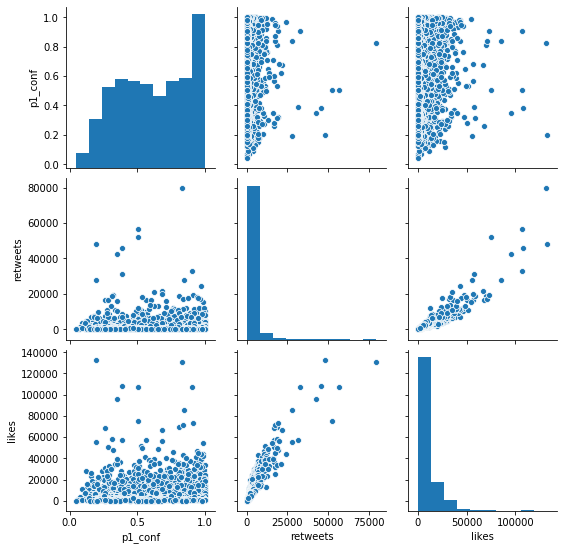

In [1256]:
# we can see the expected positive correlation of number of retweets and likes
sns.pairplot(df);

### Insight #1
### Favourite tweets are retweeted more often 

In [1257]:
df.describe()

,p1_conf,retweets,likes
count,1454.000000,1454.000000,1454.000000
mean,0.614113,2794.747593,9307.707015
std,0.261289,4790.947627,12655.167226
min,0.044333,16.000000,81.000000
25%,0.388533,653.250000,2198.500000
50%,0.615709,1440.500000,4481.500000
75%,0.855685,3264.000000,11864.000000
max,0.999956,79515.000000,132810.000000


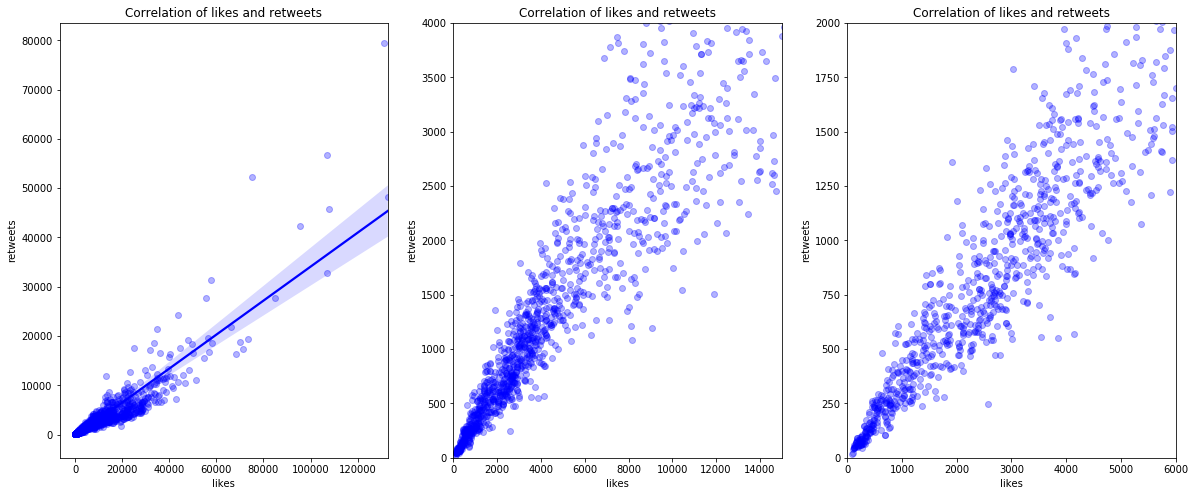

In [1258]:
# likes and retweets scatter
plt.figure(figsize=(20,8))
plt.subplot(1,3,1)
g1 = sns.regplot(x = df.likes, y = df.retweets, color='blue', scatter_kws={'alpha':0.3})
g1.set(title = 'Correlation of likes and retweets')

plt.subplot(1,3,2)
g2 = sns.regplot(x = df.likes, y = df.retweets, fit_reg=False, color='blue', scatter_kws={'alpha':0.3})
g2.set(title = 'Correlation of likes and retweets', xlim=(0,15000), ylim=(0,4000))

plt.subplot(1,3,3)
g3 = sns.regplot(x = df.likes, y = df.retweets, fit_reg=False, color='blue', scatter_kws={'alpha':0.3})
g3.set(title = 'Correlation of likes and retweets', xlim=(0,6000), ylim=(0,2000))

plt.show()

In [1259]:
df['likes'].corr(df['retweets'])

0.9108682038182967

### Insight #2
### Some of the best predicted breeds are also the most commonly tweeted ones

In [1260]:
df_pred_breeds = pd.DataFrame(df.groupby('p1')['p1_conf'].mean().nlargest(15))
df_pred_breeds

,p1_conf
p1,
komondor,0.972531
clumber,0.946718
brittany_spaniel,0.874545
keeshond,0.844431
bull_mastiff,0.815618
bernese_mountain_dog,0.801816
french_bulldog,0.770627
pug,0.760587
samoyed,0.747088


In [1261]:
breed_count = df.groupby('p1')['p1_conf'].count()
breed_count

p1
afghan_hound                        3
airedale                           12
american_staffordshire_terrier     13
appenzeller                         2
australian_terrier                  2
basenji                             7
basset                             13
beagle                             17
bedlington_terrier                  5
bernese_mountain_dog               10
black-and-tan_coonhound             2
blenheim_spaniel                    9
bloodhound                          7
bluetick                            4
border_collie                      12
border_terrier                      7
borzoi                              9
boston_bull                         9
boxer                              10
brabancon_griffon                   3
briard                              3
brittany_spaniel                    7
bull_mastiff                        5
cairn                               3
cardigan                           17
chesapeake_bay_retriever           22
chihuahua

In [1262]:
# some of the breeds predicted with the highest probability have low counts among the tweets
df_pred_breeds['breed_count'] = breed_count
df_pred_breeds

,p1_conf,breed_count
p1,,
komondor,0.972531,3
clumber,0.946718,1
brittany_spaniel,0.874545,7
keeshond,0.844431,4
bull_mastiff,0.815618,5
bernese_mountain_dog,0.801816,10
french_bulldog,0.770627,26
pug,0.760587,53
samoyed,0.747088,40


In [1263]:
df_pred_breeds.breed_count.sum()

366

In [1264]:
# top 15 best predicted breeds covers 25% of all tweets
df_pred_breeds.breed_count.sum() / len(df)

0.2517193947730399

In [1265]:
# find what komondor, the breed predicted with the highest probability, looks like
df.query('p1 == "komondor"')['jpg_url']

78      https://pbs.twimg.com/media/DBg_HT9WAAEeIMM.jpg
384     https://pbs.twimg.com/media/Cv3tU38WcAASFas.jpg
1352    https://pbs.twimg.com/media/CUd5gBGWwAA0IVA.jpg
Name: jpg_url, dtype: object

In [1266]:
# no wonder it is easy to recognize
from IPython.display import Image
Image(url='https://pbs.twimg.com/media/DBg_HT9WAAEeIMM.jpg')

In [1267]:
# now let's look at the most frequently predicted breeds
df_frequent_breeds = df.groupby('p1').count()['likes'].nlargest(15)
df_frequent_breeds

p1
golden_retriever            137
labrador_retriever           93
pembroke                     86
chihuahua                    79
pug                          53
samoyed                      40
chow                         39
pomeranian                   38
toy_poodle                   38
malamute                     29
cocker_spaniel               27
french_bulldog               26
chesapeake_bay_retriever     22
miniature_pinscher           22
siberian_husky               20
Name: likes, dtype: int64

In [1268]:
# top 15 most frequently predicted breeds covers 51% of all tweets
df.groupby('p1').count()['likes'].nlargest(15).sum() / len(df)

0.515130674002751

In [1269]:
# 5 of these breeds are also predicted with high probability
df_breeds_intersect = pd.merge(df_frequent_breeds, df_pred_breeds, on='p1', how='inner')
df_breeds_intersect.index

Index(['golden_retriever', 'pug', 'samoyed', 'pomeranian', 'french_bulldog'], dtype='object', name='p1')

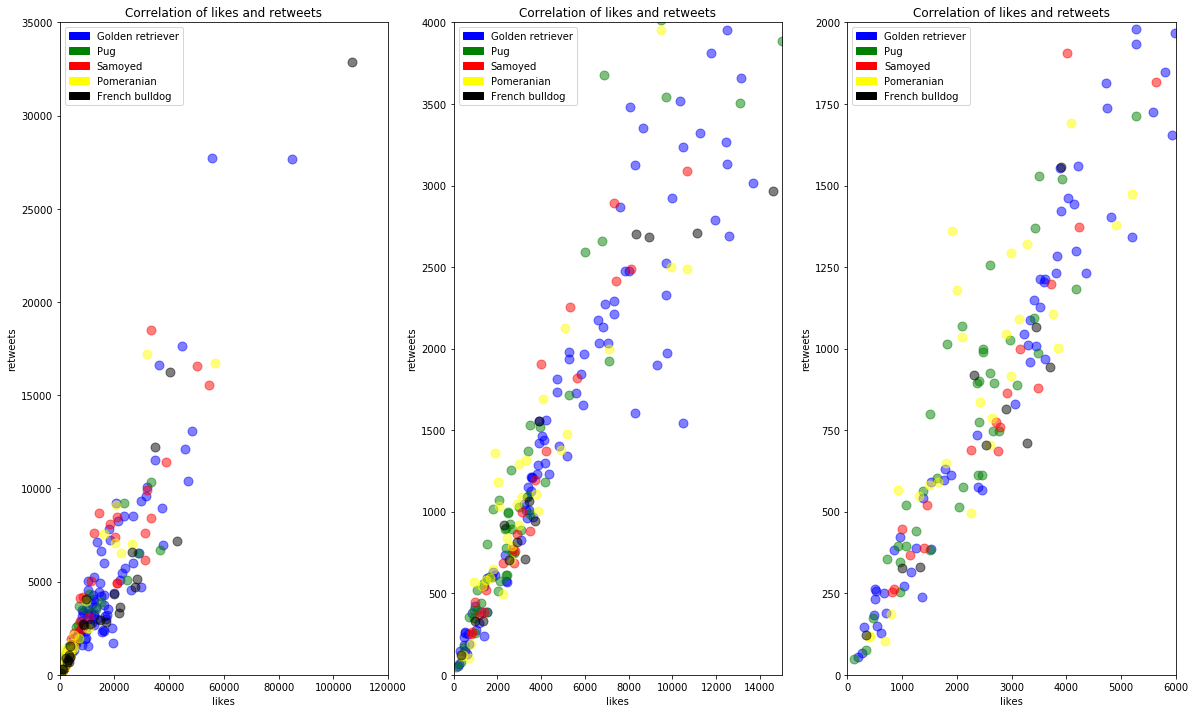

In [1270]:
# likes and retweets scatter by breeds which are both most frequently predicted and with the highest probability

# separate dfs for each breed
df_golden_retriever = df[df['p1'] == 'golden_retriever']
df_pug = df[df['p1'] == 'pug']
df_samoyed = df[df['p1'] == 'samoyed']
df_pomeranian = df[df['p1'] == 'pomeranian']
df_french_bulldog = df[df['p1'] == 'french_bulldog']

# legend
import matplotlib.patches as mpatches
ret = mpatches.Patch(label='Golden retriever', color='blue')
pug = mpatches.Patch(label='Pug', color='green')
sam = mpatches.Patch(label='Samoyed', color='red')
pom = mpatches.Patch(label='Pomeranian', color='yellow')
bull = mpatches.Patch(label='French bulldog', color='black')

plt.figure(figsize=(20,12))
plt.subplot(1,3,1)
def reg_plot(x_lim, y_lim):
    g = sns.regplot(x = df_golden_retriever.likes, y = df_golden_retriever.retweets, color='blue', scatter_kws={'alpha':0.5, 's':80}, fit_reg=False)
    sns.regplot(x = df_pug.likes, y = df_pug.retweets, color='green', scatter_kws={'alpha':0.5, 's':80}, ax=g, fit_reg=False)
    sns.regplot(x = df_samoyed.likes, y = df_samoyed.retweets, color='red', scatter_kws={'alpha':0.5, 's':80}, ax=g, fit_reg=False)
    sns.regplot(x = df_pomeranian.likes, y = df_pomeranian.retweets, color='yellow', scatter_kws={'alpha':0.5, 's':80}, ax=g, fit_reg=False)
    sns.regplot(x = df_french_bulldog.likes, y = df_french_bulldog.retweets, color='black', scatter_kws={'alpha':0.5, 's':80}, ax=g, fit_reg=False)
    g.set(title = 'Correlation of likes and retweets', xlim=(0,x_lim), ylim=(0,y_lim))
    plt.legend(handles=[ret, pug, sam, pom, bull])
    return g

reg_plot(120000, 35000)

plt.subplot(1,3,2)
reg_plot(15000, 4000)

plt.subplot(1,3,3)
reg_plot(6000, 2000)

plt.show()

### Insight #3
### Puppo tweets are the most popular

In [1271]:
df.likes.mean()

9307.707015130674

In [1272]:
# all ways below get the same result
# df['likes'].groupby(df['dog_stage']).mean()
# df.groupby('dog_stage').mean()['likes']
# df[['likes', 'dog_stage']].groupby(df['dog_stage']).mean() ... this one creates a dataframe instead of a series 
df.groupby('dog_stage')['likes'].mean()

dog_stage
None        8729.488581
doggo      19478.000000
floofer    13701.375000
pupper      8048.430556
puppo      23585.000000
Name: likes, dtype: float64

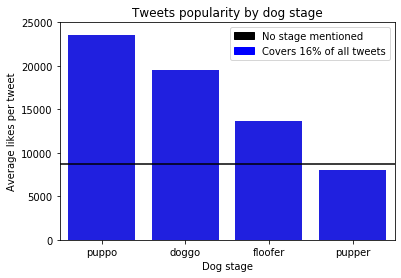

In [1273]:
sns.barplot(x = df.dog_stage, y = df.likes, order = ['puppo', 'doggo', 'floofer', 'pupper'], color = 'blue', errwidth = 0)
plt.axhline(8729, color='black')
non = mpatches.Patch(label='No stage mentioned', color='black')
cover = mpatches.Patch(label='Covers 16% of all tweets', color='blue')
plt.legend(handles=[non, cover])
plt.xlabel('Dog stage')
plt.ylabel('Average likes per tweet')
plt.title('Tweets popularity by dog stage')
plt.ylim((0,25000))
plt.show()

In [1274]:
# there are not many tweets with identified dog stage
df.groupby('dog_stage')['likes'].count()

dog_stage
None       1226
doggo        56
floofer       8
pupper      144
puppo        20
Name: likes, dtype: int64

In [1275]:
# shares
shares = df.groupby('dog_stage').agg({'dog_stage': 'count'})
shares.apply(lambda x: x / len(df))

,dog_stage
dog_stage,
None,0.843191
doggo,0.038514
floofer,0.005502
pupper,0.099037
puppo,0.013755


In [1276]:
# only 16% of tweets have a dog stagementioned in them
1 - shares.loc['None'].apply(lambda x: x / len(df))

dog_stage    0.156809
Name: None, dtype: float64

In [1277]:
# check the high likes numbers
df.query('dog_stage == "puppo"').head(5)

,timestamp,source,text,name,jpg_url,p1,p1_conf,p2,p3,retweets,likes,dog_stage,rating
10,2017-07-25 01:55:32+00:00,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Here's a puppo that seems to be on the fence about something haha no but seriously someone help her. 13/10 https://t.co/BxvuXk0UCm,Bruno,https://pbs.twimg.com/media/DFi579UWsAAatzw.jpg,pembroke,0.966327,cardigan,basenji,8538,38818,puppo,13.0/10.0
12,2017-07-24 17:02:04+00:00,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Stuart. He's sporting his favorite fanny pack. Secretly filled with bones only. 13/10 puppared puppo #BarkWeek https://t.co/y70o6h3isq,Stuart,https://pbs.twimg.com/media/DFg_2PVW0AEHN3p.jpg,golden_retriever,0.953442,labrador_retriever,redbone,2321,15359,puppo,13.0/10.0
52,2017-06-25 00:45:22+00:00,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Snoopy. He's a proud #PrideMonthPuppo. Impeccable handwriting for not having thumbs. 13/10 would love back #PrideMonth https://t.co/lNZwgNO4gS,Snoopy,https://pbs.twimg.com/media/DDIKMXzW0AEibje.jpg,italian_greyhound,0.734684,whippet,ibizan_hound,4319,19763,puppo,13.0/10.0
68,2017-06-11 21:18:31+00:00,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","This is Sebastian. He can't see all the colors of the rainbow, but he can see that this flag makes his human happy. 13/10 #PrideMonth puppo https://t.co/XBE0evJZ6V",Sebastian,https://pbs.twimg.com/media/DCEeLxjXsAAvNSM.jpg,cardigan,0.806674,pembroke,kelpie,11007,35501,puppo,13.0/10.0
91,2017-05-24 16:44:18+00:00,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Shikha. She just watched you drop a skittle on the ground and still eat it. Could not be less impressed. 12/10 superior puppo https://t.co/XZlZKd73go,Shikha,https://pbs.twimg.com/media/DAmyy8FXYAIH8Ty.jpg,eskimo_dog,0.616457,siberian_husky,malamute,2697,16755,puppo,12.0/10.0


### Insight #4
### Over 80% of all tweets use 1 of 4 most popular ratings

In [1278]:
# ratings by popularity
df.groupby('rating').count()['likes'].nlargest(10)

rating
12.0/10.0    377
10.0/10.0    313
11.0/10.0    301
13.0/10.0    215
9.0/10.0     103
8.0/10.0      56
7.0/10.0      23
14.0/10.0     22
6.0/10.0      12
5.0/10.0       9
Name: likes, dtype: int64

In [1279]:
df.groupby('rating').count()['likes'].nlargest(4).sum() / len(df)

0.8294360385144429

In [1280]:
df.groupby('rating').count()['likes'].nlargest(10).sum() / len(df)

0.984181568088033

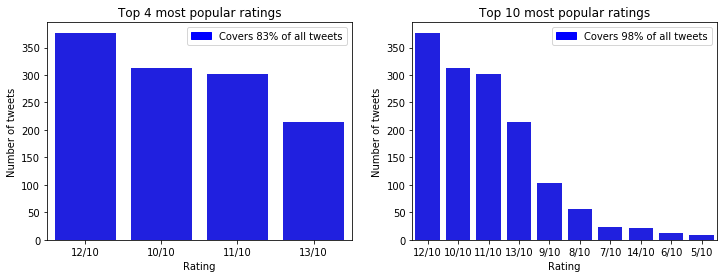

In [1281]:
plt.figure(figsize=(12,4))

plt.subplot(1,2,1)
g = sns.barplot(x = ['12/10', '10/10', '11/10', '13/10'], \
            y = df.groupby('rating').count()['likes'].nlargest(4), color = 'blue');
g.set(title = 'Top 4 most popular ratings', xlabel = 'Rating', ylabel = 'Number of tweets')
cover = mpatches.Patch(label='Covers 83% of all tweets', color='blue')
plt.legend(handles=[cover])

plt.subplot(1,2,2)
g = sns.barplot(x = ['12/10', '10/10', '11/10', '13/10', '9/10', '8/10', '7/10', '14/10', '6/10', '5/10'], \
            y = df.groupby('rating').count()['likes'].nlargest(10), color = 'blue');
g.set(title = 'Top 10 most popular ratings', xlabel = 'Rating', ylabel = 'Number of tweets')
cover = mpatches.Patch(label='Covers 98% of all tweets', color='blue')
plt.legend(handles=[cover])

plt.show()

### Insight #5
### The most popular dog name is Walter
#### However, dog names are very diverse

In [1282]:
# names by popularity
df.groupby('name').count()['likes'].nlargest(10)

name
Walter     23
Daisy      16
Cooper     14
Sadie      14
Charlie    11
Lucy       11
Oliver     11
Koda       10
Penny      10
Bella       9
Name: likes, dtype: int64

In [1283]:
# top 10 names cover only 9% of tweets
df.groupby('name').count()['likes'].nlargest(10).sum() / len(df)

0.08872077028885832

In [1284]:
# because dog names are very diverse
df.name.nunique()

759

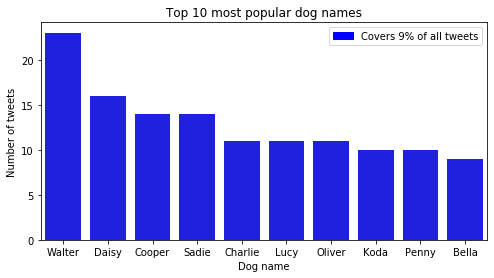

In [1285]:
plt.figure(figsize=(8,4))
g = sns.barplot(x = ['Walter', 'Daisy', 'Cooper', 'Sadie', 'Charlie', 'Lucy', 'Oliver', 'Koda', 'Penny', 'Bella'], \
            y = df.groupby('name').count()['likes'].nlargest(10), color = 'blue')

g.set(title = 'Top 10 most popular dog names', xlabel = 'Dog name', ylabel = 'Number of tweets')
cover = mpatches.Patch(label='Covers 9% of all tweets', color='blue')
plt.legend(handles=[cover])

plt.show()